In [112]:
import numpy as np
import pandas as pd
from time import time
import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)

In [113]:
FIRST_SIZE = 2
STEP_SIZE = 8
LAST_SIZE = 256 + 1 + FIRST_SIZE

COUNT_TRIES = 10

MAX_DEF_COUNT_ITER = 100000
"""Максимальное количество итераций по-умолчанию"""
DEF_EPS = 0.0001
"""Точность по-умолчанию"""

'Точность по-умолчанию'

In [114]:
df = pd.DataFrame(
    columns=[
        "size",
        "true_value_max",
        "true_value_min",
        "value_max",
        "value_max_time",
        "value_min_def",
        "value_min_def_time"
    ],
    index=range(1, ((LAST_SIZE - FIRST_SIZE) // STEP_SIZE + 1) * COUNT_TRIES + 1),
)
df

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
326,NaN,NaN,NaN,NaN,NaN,NaN,NaN
327,NaN,NaN,NaN,NaN,NaN,NaN,NaN
328,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Подготовка

In [115]:
def calc(A: np.matrix, b: np.matrix) -> float:
    """Вычисление собственного значения
    
    Вычисляется с помощью отношения Рэлея

    Args:
        A (np.matrix): Матрица
        b (np.matrix): Собственный вектор

    Returns:
        float: Собственное значение
    """
    if b is None:
        print("Вектор собственного значения не был посчитан")
        return None
    return float((b.T @ A @ b) / (b.T @ b))

# Прямой метод

$x^{(k)} = \dfrac{Ax^{(k - 1)}}{\alpha_{k - 1}}$

$\lambda_{1}(A) = \dfrac{\left( Ax^{(k)}, x^{(k)} \right)}{(x^{(k)}, x^{(k)})} = \dfrac{(x^{(k)})^{T}A^{(k)}x^{(k)}}{(x^{(k)})^{T}x^{(k)}}$, где $|\lambda_1(A)|$ - наибольшее по модулю СЗ

In [116]:
def power_iteration(
    A: np.matrix,
    epsilon: float = DEF_EPS,
    num_iterations: int = MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
    is_numpy: bool = True,
) -> np.matrix:
    """Метод прямых итераций

    Args:
        A (np.matrix): Матрица
        epsilon (float, optional): Точность. Defaults to DEF_EPS.
        num_iterations (int, optional): Количество итераций, если функция настроена работать итеративно. Defaults to MAX_DEF_COUNT_ITER.
        b_k (np.matrix, optional): Начальное приближение. Defaults to None.
        is_numpy (bool, optional): Использовать ли инверсию от numpy. Defaults to True.

    Returns:
        np.matrix: Собственный вектор
    """
    if b_k is None:
        """
        Генерировать ли начальное приближение
        """
        b_k = np.random.rand(A.shape[1], 1)

    alpha_old = None

    while True:
        b_k1 = np.dot(A, b_k)

        b_k1_norm = np.linalg.norm(b_k1)

        b_k = b_k1 / b_k1_norm

        alpha_new = calc(A, b_k)
        if alpha_old is not None and abs(alpha_new - alpha_old) < epsilon:
            break
        alpha_old = alpha_new

    return b_k, alpha_new

# Обратный метод

In [117]:
def calc_LU(A: np.matrix) -> tuple[np.matrix, np.matrix]:
    """Вычисление LU разложения

    Args:
        original (np.matrix): Исходная матрица

    Returns:
        tuple[np.matrix, np.matrix]: L и U матрица
    """

    matrixU = np.matrix(np.zeros(A.shape))

    matrixU[0] = A[0]


    matrixL = np.diag(np.ones((A.shape[0])))

    for i in range(A.shape[1]):

        matrixL[i, 0] = A[i, 0] / A[0, 0]


    for row in range(1, A.shape[0]):

        for column in range(1, A.shape[1]):

            if row <= column:

                elem_sum = sum(
                    matrixL[row, i] * matrixU[i, column] for i in range(0, row - 1 + 1)
                )


                matrixU[row, column] = A[row, column] - elem_sum

                continue

            elem_sum = sum(
                matrixL[row, i] * matrixU[i, column] for i in range(0, column - 1 + 1)
            )


            matrixL[row, column] = (A[row, column] - elem_sum) / matrixU[column, column]


    return matrixL, matrixU



def get_inverse_LU(matrix: np.matrix) -> np.matrix:
    """Получение обратной матрицы с помощью LU разложения

    Args:
        matrix (np.matrix): Исходная матрица.

    Returns:
        np.matrix: Обратная матрица.
    """

    ML, MU = calc_LU(matrix)

    out_mt = np.zeros(matrix.shape)

    for iter in range(matrix.shape[0]):

        b = np.zeros((matrix.shape[0], 1))

        b[iter] = 1

        y = np.linalg.solve(ML, b)

        x = np.linalg.solve(MU, y)

        x = x.reshape((1, matrix.shape[0]))

        out_mt[:, iter] = x
    return out_mt



def inverse_power_def(
    A: np.matrix,

    epsilon: float = DEF_EPS,
    num_iterations: int = MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
    is_numpy: bool = True,
) -> tuple[np.matrix, float]:
    """Метод обратных итераций

    Args:
        A (np.matrix): Начальная матрица
        epsilon (float, optional): Точность. Defaults to DEF_EPS.
        num_iterations (int, optional): Число итераций. Defaults to MAX_DEF_COUNT_ITER.
        b_k (np.matrix, optional): Начальное приближение. Defaults to None.
        is_numpy (bool, optional): Использовать ли инверсию от numpy. Defaults to True.

    Returns:
        tuple[np.matrix, float]: Собственный вектор и собственное значение
    """

    try:

        if is_numpy:

            inv_A = np.linalg.inv(A)
        else:


            inv_A = get_inverse_LU(A)

    except np.linalg.LinAlgError:

        print("Вырожденная матрица")

        return None

    res = power_iteration(
        A=inv_A, epsilon=epsilon, num_iterations=num_iterations, b_k=b_k
    )


    return res[0], 1 / res[1]

In [118]:
A: np.matrix = np.matrix("1 3 -2 0;"
                         "1 1 4 7;"
                         "4 7 11 23;"
                         "52 66 2 0")  # -0.65
eigvec, eigval = inverse_power_def(A)
calc(A, eigvec), eigval

(-0.6514468410902993, -0.651417007829728)

# Тестирование

## Подготовка

In [119]:
def output(
    A: np.matrix,
    funcs_names: list[str],
    funcs: list,
    is_numpy: bool = True,
    num_iterations: int = MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
) -> tuple[np.matrix, list[float | None]]:
    """Функция-тестировщик

    Args:
        A (np.matrix): Исходная матрица
        funcs_names (list[str]): Названия функций
        funcs (list): функции
        is_numpy (bool, optional): Использовать ли инверсию от numpy. Defaults to True. Defaults to True.
        num_iterations (int, optional): Количество итераций. Defaults to MAX_DEF_COUNT_ITER.
        b_k (np.matrix, optional): Начальное приближение. Defaults to None.

    Returns:
        tuple[np.matrix, list[float | None]]: Выходные данные. Размер, максимальное СЗ, минимальное СЗ и list[float, float], состоящий из полученного приближения и затраченного времени
    """

    eigs = np.linalg.eigvals(A)
    if any(isinstance(eig, np.complex128) for eig in eigs):
        print(eigs)

    abs_v = np.abs(np.linalg.eigvals(A))

    abs_v_max = np.max(abs_v)

    abs_v_min = np.min(abs_v)

    mass_eval = []

    for func_name, f in zip(funcs_names, funcs):
        start_time = time()
        evec, eval = f(A=A, b_k=b_k, num_iterations=num_iterations, is_numpy=is_numpy)
        stop_time = time()
        mass_eval.append(abs(eval))
        mass_eval.append(stop_time - start_time)

    return A.shape[0], abs_v_max, abs_v_min, *mass_eval

In [120]:
def generate_non_singular(n: int) -> np.matrix:
    """Генерация невырожденной матрицы

    Args:
        n (int): Размерность матрицы

    Returns:
        np.matrix: Невырожденная матрица
    """
    while True:
        matrix = np.random.rand(n, n)
        if np.linalg.det(matrix) != 0:
            return matrix

In [121]:
funcs_names = ["Прямые итерации", "Обратные итерации (обычные)"]
funcs = [power_iteration, inverse_power_def]

## Тестирование на заранее заготовленных матрицах

In [122]:
A = np.array([[11, 2, 5], [2, 7, 3], [5, 3, 11]])
size, true_value_max, true_value_min, value_max, _, value_min_def, _ = output(A, funcs_names=funcs_names, funcs=funcs)
true_value_max, value_max, true_value_min, value_min_def

(np.float64(17.22753579693707),
 17.227531204560552,
 np.float64(5.209270633258371),
 5.213844892612415)

In [123]:
A = np.array([[17, -3, 7], [-3, 22, 8], [7, 8, 11]])
size, true_value_max, true_value_min, value_max, _, value_min_def, _ = output(A, funcs_names=funcs_names, funcs=funcs)
true_value_max, value_max, true_value_min, value_min_def

(np.float64(26.266048432199927),
 26.265925266498314,
 np.float64(2.7443535938170776),
 2.7443547504425916)

In [124]:
A = np.array([[1, 2, 4], [4, 5, 6], [7, 8, 9]])
size, true_value_max, true_value_min, value_max, _, value_min_def, _ = output(A, funcs_names=funcs_names, funcs=funcs)
true_value_max, value_max, true_value_min, value_min_def

(np.float64(16.503789400306477),
 16.503791558967418,
 np.float64(0.11246753586075879),
 0.11246761442487138)

## Тестирование на случайных симметричных матрицах

Симметричные матрицы необходимы для вещественных корней

In [125]:
for i in range(FIRST_SIZE, LAST_SIZE + 1, STEP_SIZE):
    print(f"Current size:{i}")
    for j in range(COUNT_TRIES):
        print(j + 1)
        matr = generate_non_singular(i)
        matr = matr @ matr.T
        # Пришлось ввести симметричную матрицу из-за комплексных корней
        df.iloc[((i - FIRST_SIZE) // STEP_SIZE) * COUNT_TRIES + j] = output(A=matr, funcs_names=funcs_names, funcs=funcs, is_numpy=False)
    print()

df["delta_max"] = abs(df["true_value_max"] - df["value_max"])
df["delta_min_def"] = abs(df["true_value_min"] - df["value_min_def"])

res_df = df[["size", "value_max_time", "value_min_def_time", "delta_max", "delta_min_def"]]

df

Current size:2
1
2
3
4
5
6
7
8
9
10

Current size:10
1
2
3
4
5
6
7
8
9
10

Current size:18
1
2
3
4
5
6
7
8
9
10

Current size:26
1
2
3
4
5
6
7
8
9
10

Current size:34
1
2
3
4
5
6
7
8
9
10

Current size:42
1
2
3
4
5
6
7
8
9
10

Current size:50
1
2
3
4
5
6
7
8
9
10

Current size:58
1
2
3
4
5
6
7
8
9
10

Current size:66
1
2
3
4
5
6
7
8
9
10

Current size:74
1
2
3
4
5
6
7
8
9
10

Current size:82
1
2
3
4
5
6
7
8
9
10

Current size:90
1
2
3
4
5
6
7
8
9
10

Current size:98
1
2
3
4
5
6
7
8
9
10

Current size:106
1
2
3
4
5
6
7
8
9
10

Current size:114
1
2
3
4
5
6
7
8
9
10

Current size:122
1
2
3
4
5
6
7
8
9
10

Current size:130
1
2
3
4
5
6
7
8
9
10

Current size:138
1
2
3
4
5
6
7
8
9
10

Current size:146
1
2
3
4
5
6
7
8
9
10

Current size:154
1
2
3
4
5
6
7
8
9
10

Current size:162
1
2
3
4
5
6
7
8
9
10

Current size:170
1
2
3
4
5
6
7
8
9
10

Current size:178
1
2
3
4
5
6
7
8
9
10

Current size:186
1
2
3
4
5
6
7
8
9
10

Current size:194
1
2
3
4
5
6
7
8
9
10

Current size:202
1
2
3
4
5
6
7
8
9
10



,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,delta_max,delta_min_def
1,2,1.362239,0.003585,1.362239,0.0,0.003585,0.0,0.0,0.0
2,2,1.846869,0.012325,1.846869,0.0,0.012325,0.0,0.0,0.0
3,2,2.263394,0.057988,2.263394,0.001003,0.057988,0.0,0.0,0.0
4,2,1.823117,0.217491,1.823116,0.0,0.217491,0.0,0.000001,0.0
5,2,1.338489,0.005895,1.338489,0.0,0.005895,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
326,258,16718.989454,0.000561,16718.989454,0.0,0.000561,4.003405,0.0,0.0
327,258,16629.669796,0.000012,16629.669796,0.0,0.000012,4.04958,0.0,0.0
328,258,16645.132766,0.000365,16645.132766,0.0,0.000365,4.033066,0.0,0.0
329,258,16820.969689,0.001195,16820.969689,0.0,0.001195,4.020143,0.0,0.0


In [126]:
df

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,delta_max,delta_min_def
1,2,1.362239,0.003585,1.362239,0.0,0.003585,0.0,0.0,0.0
2,2,1.846869,0.012325,1.846869,0.0,0.012325,0.0,0.0,0.0
3,2,2.263394,0.057988,2.263394,0.001003,0.057988,0.0,0.0,0.0
4,2,1.823117,0.217491,1.823116,0.0,0.217491,0.0,0.000001,0.0
5,2,1.338489,0.005895,1.338489,0.0,0.005895,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
326,258,16718.989454,0.000561,16718.989454,0.0,0.000561,4.003405,0.0,0.0
327,258,16629.669796,0.000012,16629.669796,0.0,0.000012,4.04958,0.0,0.0
328,258,16645.132766,0.000365,16645.132766,0.0,0.000365,4.033066,0.0,0.0
329,258,16820.969689,0.001195,16820.969689,0.0,0.001195,4.020143,0.0,0.0


In [127]:
df.sort_values("delta_max", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,delta_max,delta_min_def
4,2,1.823117,0.217491,1.823116,0.0,0.217491,0.0,0.000001,0.0
30,18,85.523232,0.003254,85.523231,0.0,0.003254,0.0,0.0,0.0
19,10,26.573112,0.000573,26.573112,0.0,0.000573,0.0,0.0,0.0
16,10,26.799342,0.002961,26.799341,0.0,0.002961,0.0,0.0,0.0
13,10,28.357061,0.003751,28.357061,0.0,0.003751,0.0,0.0,0.0
26,18,82.781586,0.002912,82.781586,0.0,0.002912,0.0,0.0,0.0
15,10,26.119717,0.005595,26.119717,0.0,0.005595,0.0,0.0,0.0
14,10,25.572471,0.001589,25.572471,0.0,0.001589,0.0,0.0,0.0
10,2,1.449754,0.133818,1.449754,0.0,0.133818,0.0,0.0,0.0
22,18,79.685714,0.001118,79.685714,0.000203,0.001118,0.002782,0.0,0.0


In [128]:
df.sort_values("delta_min_def", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,delta_max,delta_min_def
75,58,849.238496,0.010938,849.238496,0.0,0.010938,0.044638,0.0,0.0
170,130,4254.977296,0.002906,4254.977296,0.0,0.002906,0.517134,0.0,0.0
138,106,2821.407457,0.004084,2821.407457,0.0,0.004084,0.271384,0.0,0.0
25,18,80.613274,0.009511,80.613274,0.0,0.009511,0.0,0.0,0.0
34,26,177.161949,0.01218,177.161949,0.0,0.01218,0.005001,0.0,0.0
4,2,1.823117,0.217491,1.823116,0.0,0.217491,0.0,0.000001,0.0
225,178,8012.512325,0.002115,8012.512325,0.0,0.002115,1.327544,0.0,0.0
62,50,621.421716,0.003985,621.421716,0.0,0.003985,0.032339,0.0,0.0
98,74,1354.225634,0.005619,1354.225634,0.0,0.005619,0.109772,0.0,0.0
72,58,866.986027,0.005199,866.986027,0.0,0.005199,0.049374,0.0,0.0


In [129]:
max(res_df["delta_min_def"])

np.float64(3.090690085805203e-08)

In [130]:
mean_df = res_df.groupby("size").mean()
mean_df

,value_max_time,value_min_def_time,delta_max,delta_min_def
size,,,,
2,0.000112,0.00007,0.0,0.0
10,0.0,0.0,0.0,0.0
18,0.00002,0.003274,0.0,0.0
26,0.0,0.004564,0.0,0.0
34,0.0,0.011792,0.0,0.0
42,0.0,0.018719,0.0,0.0
50,0.0,0.030895,0.0,0.0
58,0.0,0.049688,0.0,0.0
66,0.0,0.070386,0.0,0.0


In [131]:
max(mean_df['delta_min_def'])

3.1601219854795283e-09

# Графическая часть

In [155]:
import matplotlib.pyplot as plt

In [156]:
figsize = (18, 6)
b_k = range(FIRST_SIZE, LAST_SIZE + 1, STEP_SIZE * 1)
x_lt = np.linspace(FIRST_SIZE, LAST_SIZE)
res_df

,size,value_max_time,value_min_def_time,delta_max,delta_min_def
1,2,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0
3,2,0.001003,0.0,0.0,0.0
4,2,0.0,0.0,0.000001,0.0
5,2,0.0,0.0,0.0,0.0
...,...,...,...,...,...
326,258,0.0,4.003405,0.0,0.0
327,258,0.0,4.04958,0.0,0.0
328,258,0.0,4.033066,0.0,0.0
329,258,0.0,4.020143,0.0,0.0


<Figure size 1800x600 with 0 Axes>

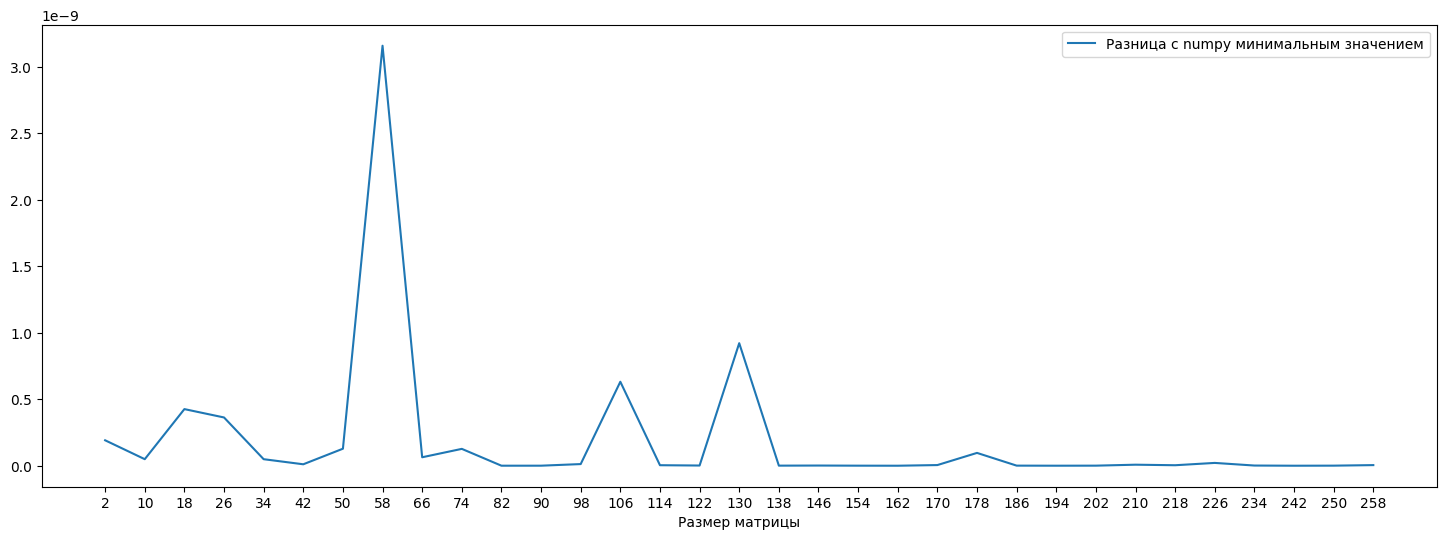

In [157]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)
ax1.set_xticks(ticks=b_k)
ax1.set_xlabel('Размер матрицы')

plt.plot(mean_df["delta_min_def"], label="Разница с numpy минимальным значением")
plt.legend()

plt.savefig('img/diff_min.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1800x600 with 0 Axes>

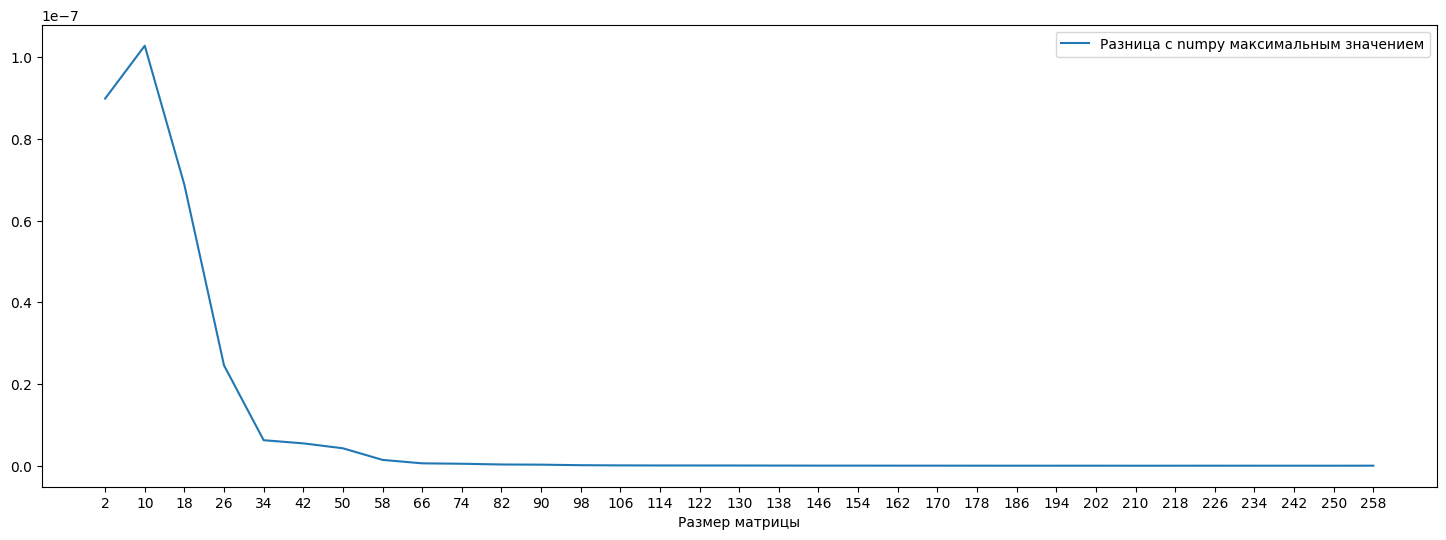

In [158]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)
ax1.set_xticks(ticks=b_k)
ax1.set_xlabel('Размер матрицы')

plt.plot(mean_df["delta_max"], label="Разница с numpy максимальным значением")
plt.legend()

plt.savefig('img/diff_max.png', dpi=300, bbox_inches='tight')
plt.show()

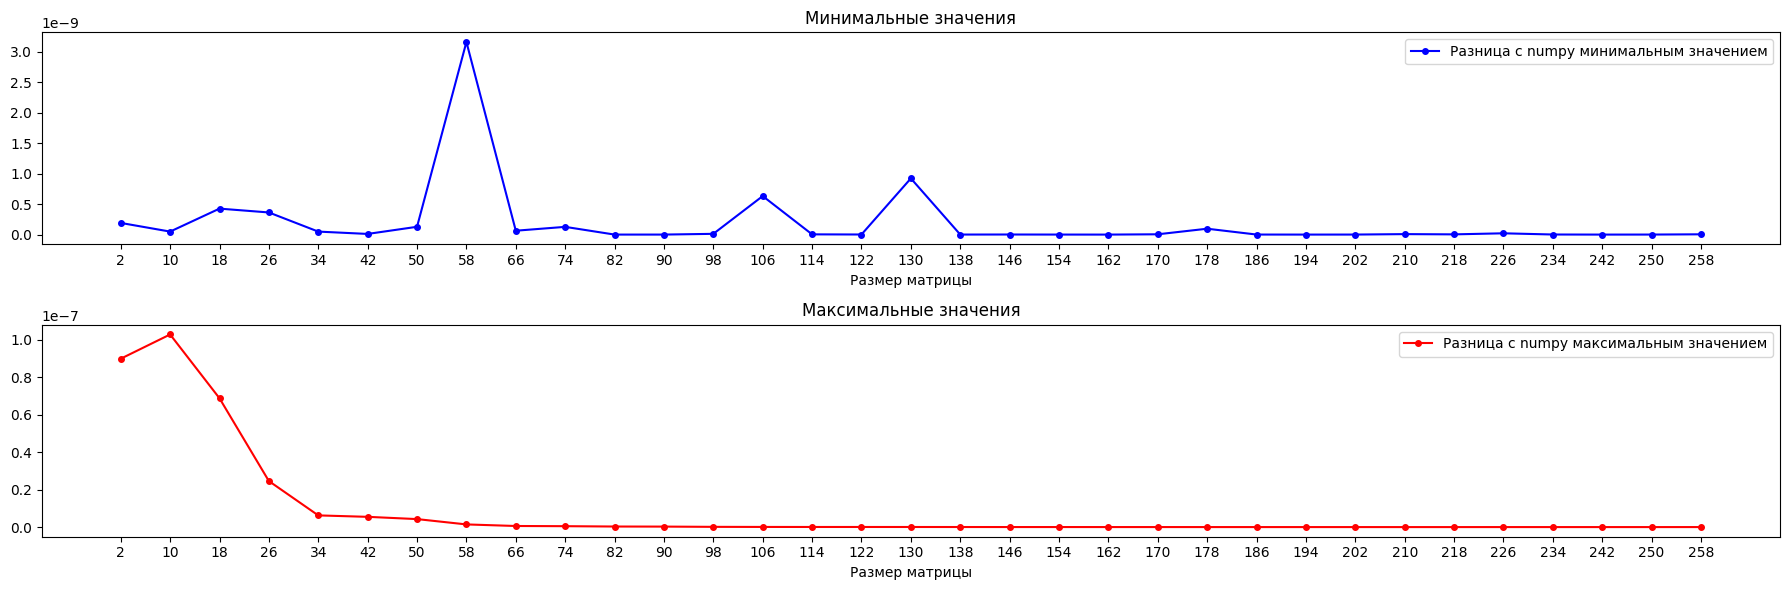

In [159]:
# Create a single figure with two subplots (one on top of the other)
fig, (ax_min, ax_max) = plt.subplots(2, 1, figsize=figsize)

# Plot for minimal values in the top half
ax_min.set_xticks(b_k)
ax_min.set_xlabel("Размер матрицы")
ax_min.plot(
    mean_df["delta_min_def"],
    label="Разница с numpy минимальным значением",
    marker="o",
    markersize=4,
    color="blue",
)
ax_min.legend()
ax_min.set_title("Минимальные значения")

# Plot for maximal values in the bottom half
ax_max.set_xticks(b_k)
ax_max.set_xlabel("Размер матрицы")
ax_max.plot(
    mean_df["delta_max"],
    label="Разница с numpy максимальным значением",
    marker="o",
    markersize=4,
    color="red",
)
ax_max.legend()
ax_max.set_title("Максимальные значения")

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the combined figure
plt.savefig("img/diff_combined.png", dpi=300, bbox_inches="tight")

# Show the combined figure
plt.show()

<Figure size 1800x600 with 0 Axes>

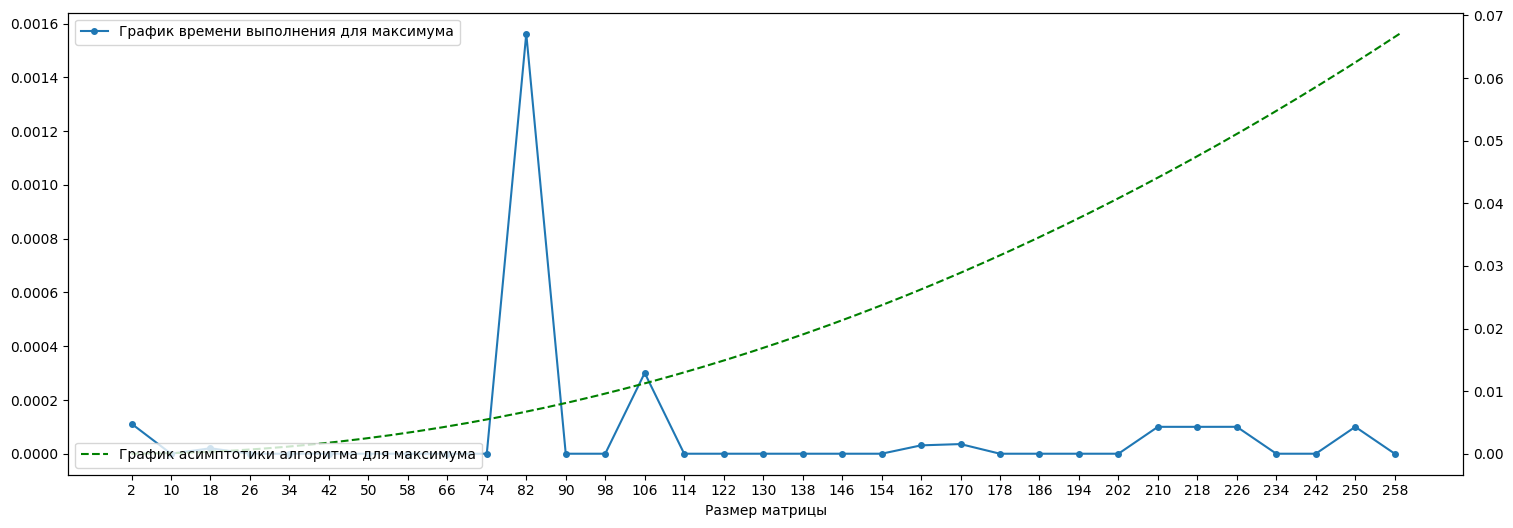

In [160]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)

ax1.plot(
    mean_df["value_max_time"],
    marker="o",
    markersize=4,
    label="График времени выполнения для максимума",
)
ax1.set_xlabel("Размер матрицы")
ax1.set_xticks(b_k)

ax2 = ax1.twinx()

ax2.plot(
    x_lt,
    (x_lt**2) / 1e6,
    color="green",
    linestyle="--",
    label="График асимптотики алгоритма для максимума",
)

ax1.legend(loc="upper left")
ax2.legend(loc="lower left")

plt.savefig('img/time_max.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1800x600 with 0 Axes>

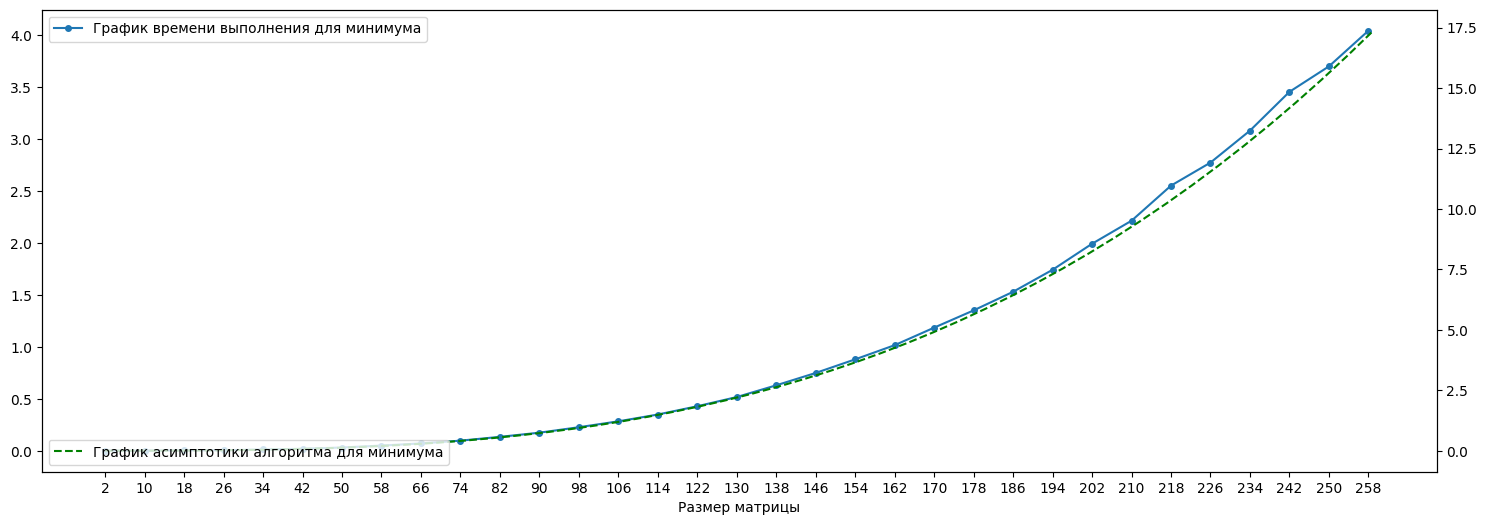

In [161]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)

ax1.plot(
    mean_df["value_min_def_time"],
    marker="o",
    markersize=4,
    label="График времени выполнения для минимума",
)
ax1.set_xlabel("Размер матрицы")
ax1.set_xticks(b_k)

ax2 = ax1.twinx()

ax2.plot(
    x_lt,
    (x_lt**3) / 1e6,
    color="green",
    linestyle="--",
    label="График асимптотики алгоритма для минимума",
)


ax1.legend(loc="upper left")
ax2.legend(loc="lower left")

plt.savefig('img/time_min.png', dpi=300, bbox_inches='tight')
plt.show()

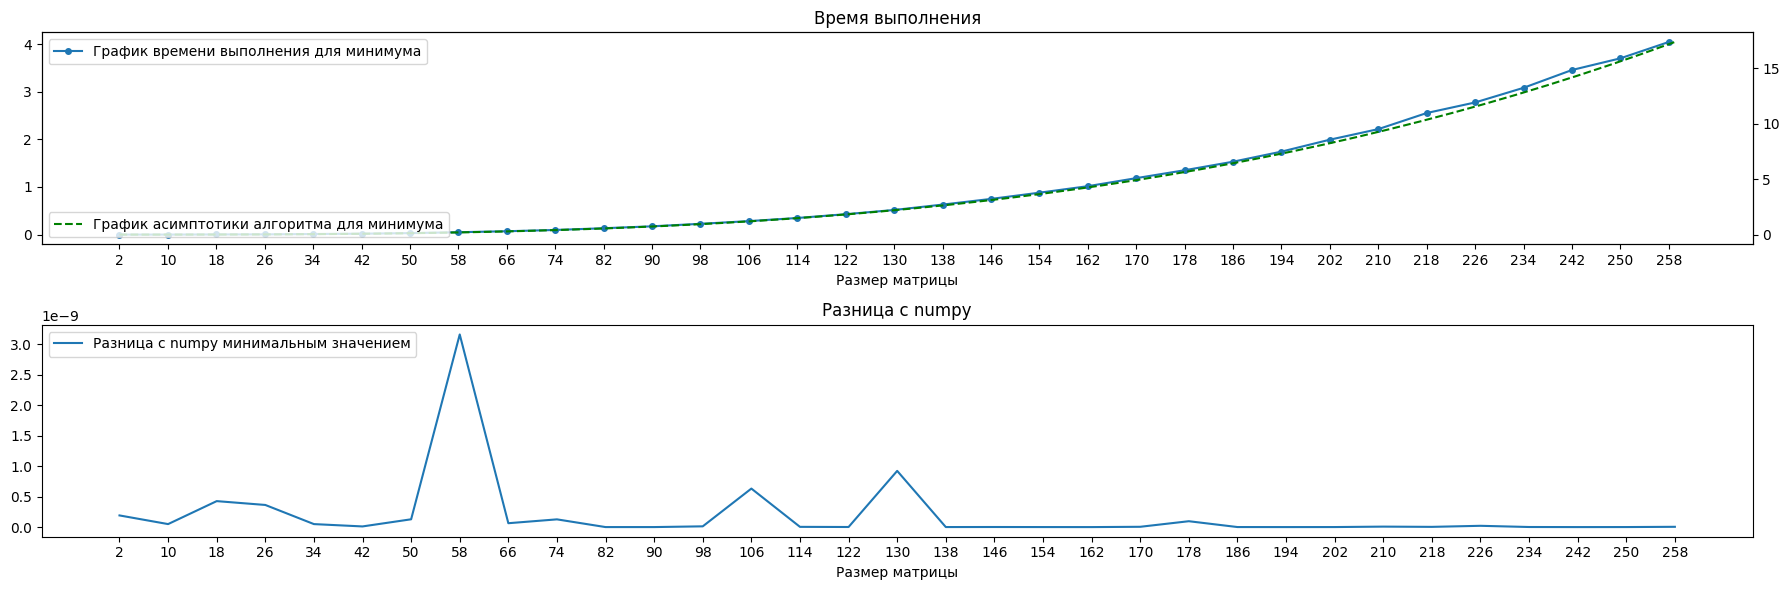

In [162]:
# Assuming b_k, mean_df, and x_lt are already defined.
plt.figure(figsize=figsize)

# Create the first subplot for time execution
ax1 = plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
ax1.plot(
    mean_df["value_min_def_time"],
    marker="o",
    markersize=4,
    label="График времени выполнения для минимума",
)
ax1.set_xlabel("Размер матрицы")
ax1.set_xticks(b_k)
ax1.set_title("Время выполнения")
ax1.legend(loc="upper left")

ax2_u = ax1.twinx()

ax2_u.plot(
    x_lt,
    (x_lt**3) / 1e6,
    color="green",
    linestyle="--",
    label="График асимптотики алгоритма для минимума",
)
ax2_u.legend(loc="lower left")


# Create the second subplot for the difference calculation
ax2 = plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
ax2.plot(
    mean_df["delta_min_def"],
    label="Разница с numpy минимальным значением"
)
ax2.set_xlabel("Размер матрицы")
ax2.set_xticks(b_k)
ax2.set_title("Разница с numpy")
ax2.legend(loc="upper left")

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the combined figure with the two plots
plt.savefig('img/time_min_combined.png', dpi=300, bbox_inches='tight')
plt.show()

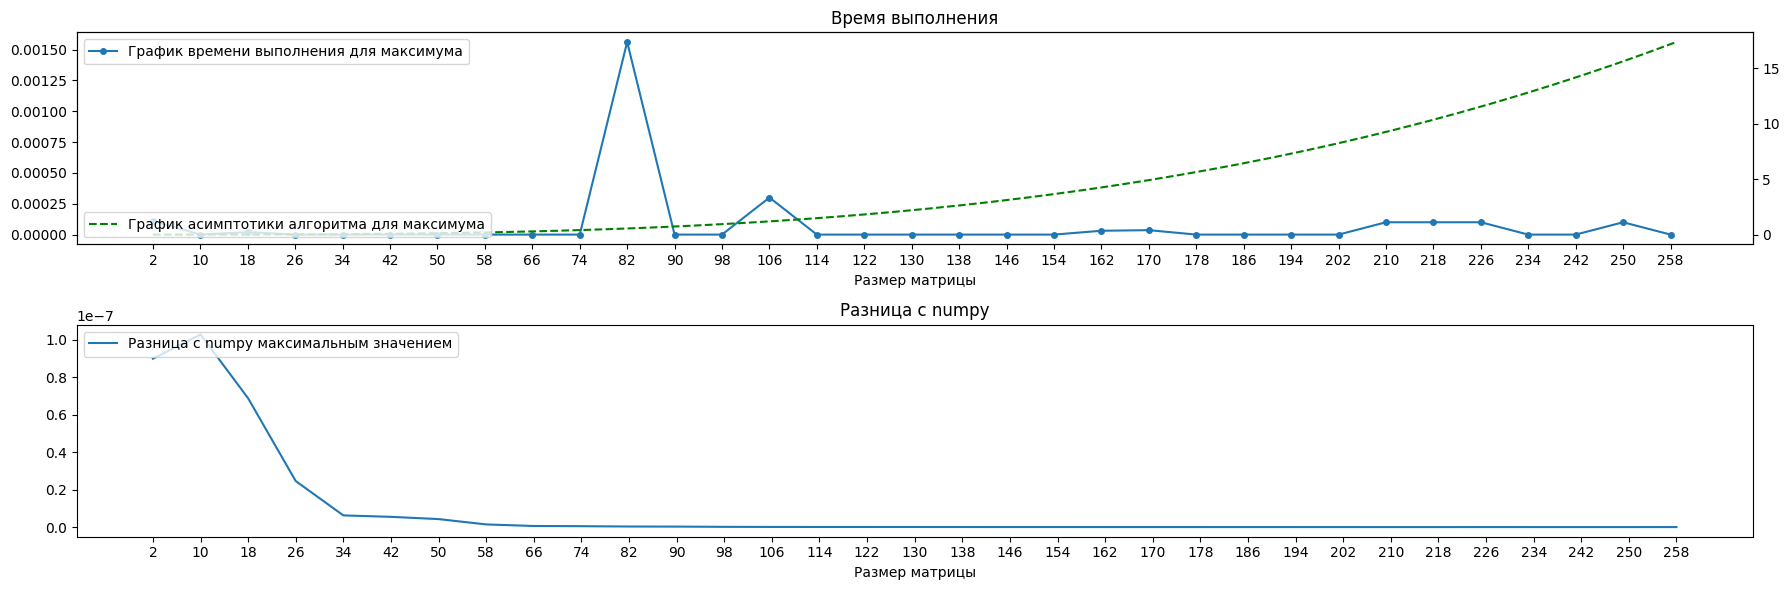

In [163]:
# Assuming b_k, mean_df, and x_lt are already defined.
plt.figure(figsize=figsize)

# Create the first subplot for time execution
ax1 = plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
ax1.plot(
    mean_df["value_max_time"],
    marker="o",
    markersize=4,
    label="График времени выполнения для максимума",
)
ax1.set_xlabel("Размер матрицы")
ax1.set_xticks(b_k)
ax1.set_title("Время выполнения")
ax1.legend(loc="upper left")

ax2_u = ax1.twinx()

ax2_u.plot(
    x_lt,
    (x_lt**3) / 1e6,
    color="green",
    linestyle="--",
    label="График асимптотики алгоритма для максимума",
)
ax2_u.legend(loc="lower left")


# Create the second subplot for the difference calculation
ax2 = plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
ax2.plot(
    mean_df["delta_max"],
    label="Разница с numpy максимальным значением"
)
ax2.set_xlabel("Размер матрицы")
ax2.set_xticks(b_k)
ax2.set_title("Разница с numpy")
ax2.legend(loc="upper left")

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the combined figure with the two plots
plt.savefig('img/time_max_combined.png', dpi=300, bbox_inches='tight')
plt.show()

# Дополнительная часть

## Вычисление

In [164]:
ddf = pd.DataFrame(
    columns=[
        "size",
        "true_value_max",
        "true_value_min",
        "value_min_def",
        "value_min_def_time"
    ],
    index=range(1, ((LAST_SIZE - FIRST_SIZE) // STEP_SIZE + 1) * COUNT_TRIES + 1),
)
ddf

,size,true_value_max,true_value_min,value_min_def,value_min_def_time
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
326,NaN,NaN,NaN,NaN,NaN
327,NaN,NaN,NaN,NaN,NaN
328,NaN,NaN,NaN,NaN,NaN
329,NaN,NaN,NaN,NaN,NaN


In [165]:
ffuncs_names = ["Обратные итерации (обычные)"]
ffuncs = [inverse_power_def]

In [166]:
for i in range(FIRST_SIZE, LAST_SIZE + 1, STEP_SIZE):
    print(f"Current size:{i}")
    for j in range(COUNT_TRIES):
        print(j + 1)
        matr = generate_non_singular(i)
        matr = matr @ matr.T
        # Пришлось ввести симметричную матрицу из-за комплексных корней
        ddf.iloc[((i - FIRST_SIZE) // STEP_SIZE) * COUNT_TRIES + j] = output(A=matr, funcs_names=ffuncs_names, funcs=ffuncs, is_numpy=True)
    print()

ddf["delta_min_def"] = abs(ddf["true_value_min"] - ddf["value_min_def"])

ddf

Current size:2
1
2
3
4
5
6
7
8
9
10

Current size:10
1
2
3
4
5
6
7
8
9
10

Current size:18
1
2
3
4
5
6
7
8
9
10

Current size:26
1
2
3
4
5
6
7
8
9
10

Current size:34
1
2
3
4
5
6
7
8
9
10

Current size:42
1
2
3
4
5
6
7
8
9
10

Current size:50
1
2
3
4
5
6
7
8
9
10

Current size:58
1
2
3
4
5
6
7
8
9
10

Current size:66
1
2
3
4
5
6
7
8
9
10

Current size:74
1
2
3
4
5
6
7
8
9
10

Current size:82
1
2
3
4
5
6
7
8
9
10

Current size:90
1
2
3
4
5
6
7
8
9
10

Current size:98
1
2
3
4
5
6
7
8
9
10

Current size:106
1
2
3
4
5
6
7
8
9
10

Current size:114
1
2
3
4
5
6
7
8
9
10

Current size:122
1
2
3
4
5
6
7
8
9
10

Current size:130
1
2
3
4
5
6
7
8
9
10

Current size:138
1
2
3
4
5
6
7
8
9
10

Current size:146
1
2
3
4
5
6
7
8
9
10

Current size:154
1
2
3
4
5
6
7
8
9
10

Current size:162
1
2
3
4
5
6
7
8
9
10

Current size:170
1
2
3
4
5
6
7
8
9
10

Current size:178
1
2
3
4
5
6
7
8
9
10

Current size:186
1
2
3
4
5
6
7
8
9
10

Current size:194
1
2
3
4
5
6
7
8
9
10

Current size:202
1
2
3
4
5
6
7
8
9
10



,size,true_value_max,true_value_min,value_min_def,value_min_def_time,delta_min_def
1,2,1.414135,0.103632,0.103632,0.000999,0.0
2,2,1.168247,0.167951,0.167951,0.0,0.0
3,2,1.048287,0.047824,0.047824,0.001002,0.0
4,2,0.788412,0.128259,0.128259,0.0,0.0
5,2,1.28637,0.099184,0.099184,0.0,0.0
...,...,...,...,...,...,...
326,258,16794.69131,0.000384,0.000384,0.062533,0.0
327,258,16840.601252,0.000338,0.000338,0.088473,0.0
328,258,16787.989017,0.000013,0.000013,0.110119,0.0
329,258,16750.606341,0.000023,0.000023,0.080403,0.0


In [167]:
res_ddf = ddf[["size", "value_min_def_time", "delta_min_def"]]

mean_ddf = res_ddf.groupby("size").mean()
mean_ddf

,value_min_def_time,delta_min_def
size,,
2,0.0002,0.0
10,0.000112,0.0
18,0.0001,0.0
26,0.000118,0.0
34,0.000401,0.0
42,0.0,0.0
50,0.000204,0.0
58,0.00022,0.0
66,0.0001,0.0


## Графики

<Figure size 1800x600 with 0 Axes>

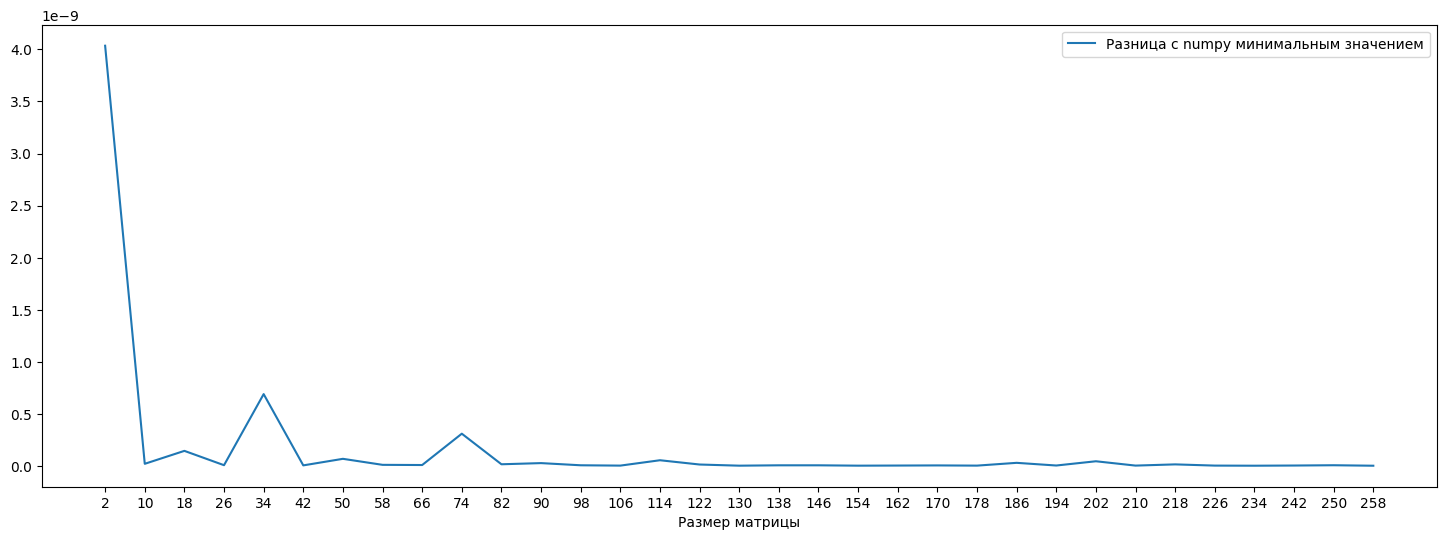

In [168]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)
ax1.set_xticks(ticks=b_k)
ax1.set_xlabel('Размер матрицы')

plt.plot(mean_ddf["delta_min_def"], label="Разница с numpy минимальным значением")
plt.legend()

plt.savefig('img/diff_min_numpy.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1800x600 with 0 Axes>

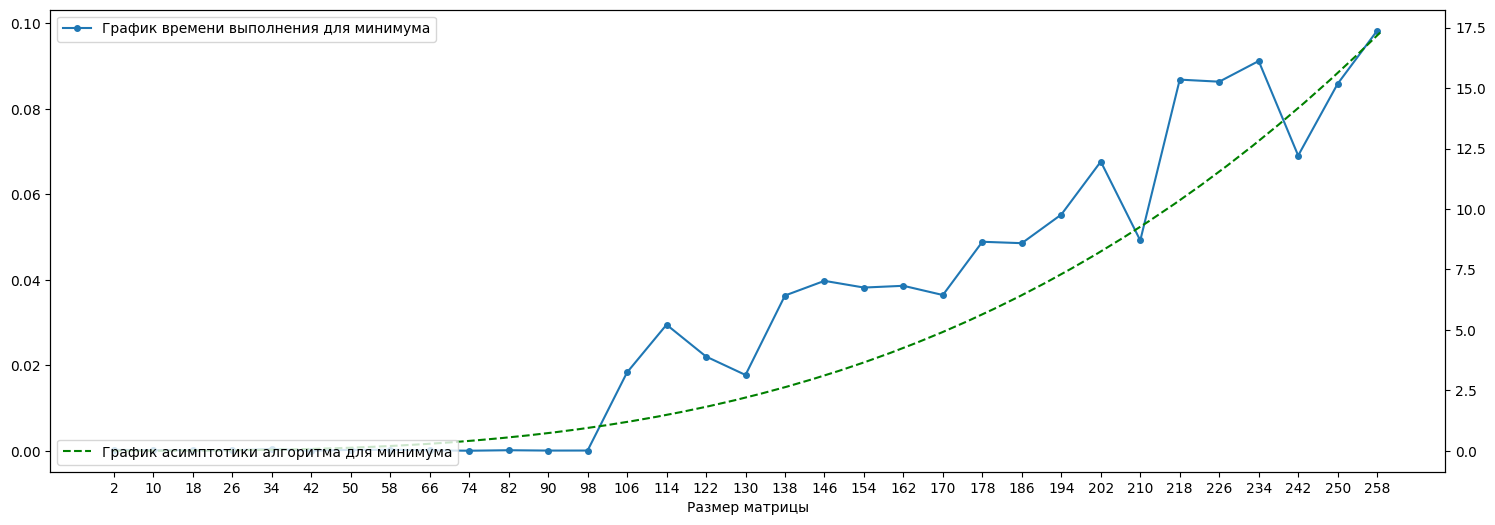

In [169]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)

ax1.plot(
    mean_ddf["value_min_def_time"],
    marker="o",
    markersize=4,
    label="График времени выполнения для минимума",
)
ax1.set_xlabel("Размер матрицы")
ax1.set_xticks(b_k)

ax2 = ax1.twinx()

ax2.plot(
    x_lt,
    (x_lt**3) / 1e6,
    color="green",
    linestyle="--",
    label="График асимптотики алгоритма для минимума",
)


ax1.legend(loc="upper left")
ax2.legend(loc="lower left")

plt.savefig('img/time_min_numpy.png', dpi=300, bbox_inches='tight')
plt.show()

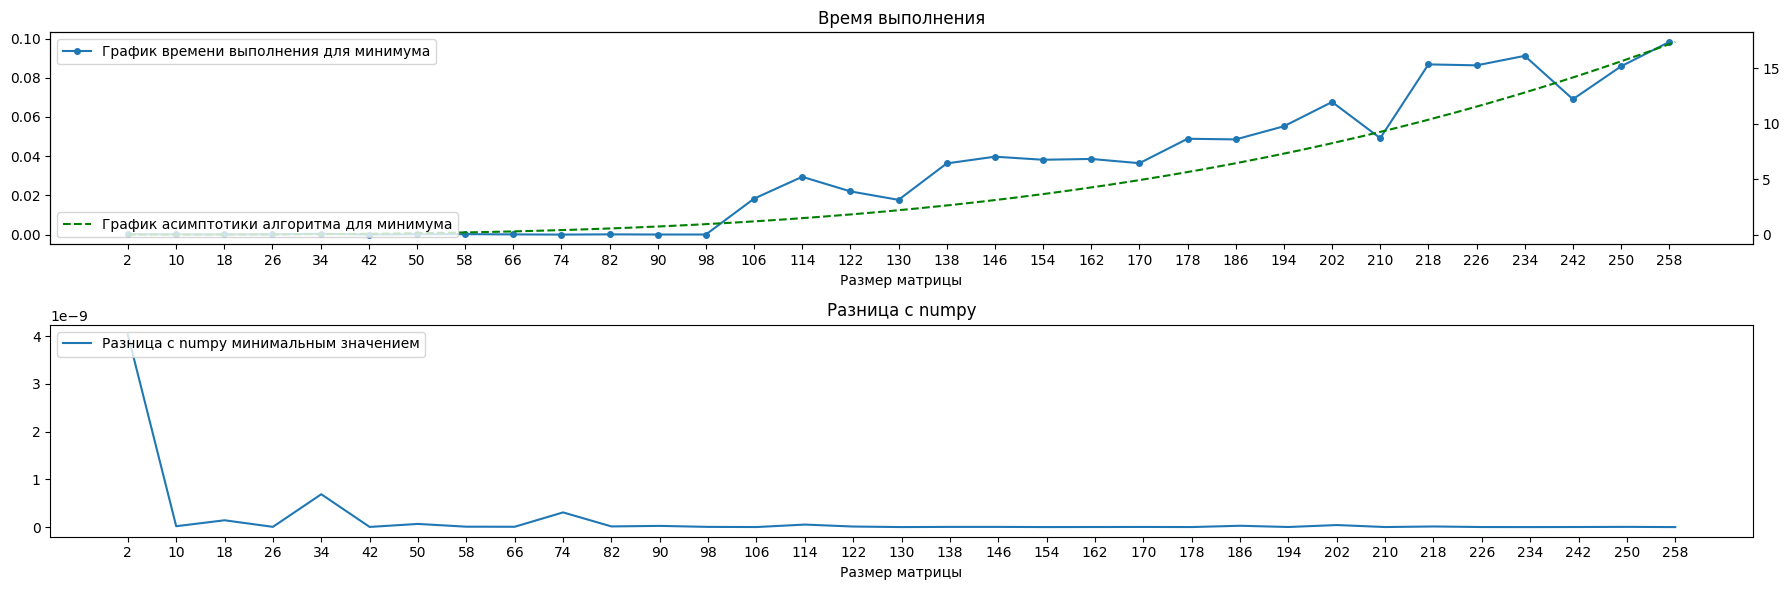

In [170]:
# Assuming b_k, mean_df, and x_lt are already defined.
plt.figure(figsize=figsize)

# Create the first subplot for time execution
ax1 = plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
ax1.plot(
    mean_ddf["value_min_def_time"],
    marker="o",
    markersize=4,
    label="График времени выполнения для минимума",
)
ax1.set_xlabel("Размер матрицы")
ax1.set_xticks(b_k)
ax1.set_title("Время выполнения")
ax1.legend(loc="upper left")

ax2_u = ax1.twinx()

ax2_u.plot(
    x_lt,
    (x_lt**3) / 1e6,
    color="green",
    linestyle="--",
    label="График асимптотики алгоритма для минимума",
)
ax2_u.legend(loc="lower left")


# Create the second subplot for the difference calculation
ax2 = plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
ax2.plot(
    mean_ddf["delta_min_def"],
    label="Разница с numpy минимальным значением"
)
ax2.set_xlabel("Размер матрицы")
ax2.set_xticks(b_k)
ax2.set_title("Разница с numpy")
ax2.legend(loc="upper left")

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the combined figure with the two plots
plt.savefig('img/time_min_combined_numpy.png', dpi=300, bbox_inches='tight')
plt.show()